# k-means clustering using GEE

This assignment explores the use of unsupervised [k-means clustering algorithm of GEE](https://developers.google.com/earth-engine/guides/clustering) to classify a summer 2023 image of the country Italy. The unsupervised algorithm is compared with the available reference dataset to check if the classified clusters are belonging to any specific landcover category.

In [1]:
import os
import dask
import dask.dataframe as dd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

As the reference dataset given is a folder of large csv files, Dask is used perform the reading of the files in a distributed manner.

In [4]:
from dask.distributed import Client
client = Client()
# client

In [3]:
# client.shutdown()

In [5]:
import ee
import geemap

In [7]:
ee.Authenticate()

Enter verification code:  4/1AfJohXl522CXTg0nCAykmVPwLfE2ALdz_lkl4e8QWif1oZSHOaW6JckxNV0



Successfully saved authorization token.


In [8]:
try:
  ee.Initialize()
  print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
  print('Google Earth Engine has failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

Google Earth Engine has initialized successfully!


### Bounding Box

We use the country bounding box available in this link : https://gist.github.com/graydon/11198540

In [9]:
import countrybb
country_bounding_boxes = countrybb.country_bounding_boxes

In [10]:
cbb = countrybb.country_bounding_boxes['IT'][1]
print(cbb)
# print (cbb[0], cbb[1], cbb[2], cbb[3])

roi = ee.Geometry.Rectangle(cbb[0], cbb[1], cbb[2], cbb[3])

(6.7499552751, 36.619987291, 18.4802470232, 47.1153931748)


### Filter Reference Points

Using dask distributed, 9 csv files from the data folder are read in parallel into on dask dataframe that is used to filter reference points within the bounding box.

In [11]:
ddf = dd.read_csv(
    os.path.join("data","SamplesSet*.csv"),
    dtype={"landcover": str, "lat": float, "long": float},
)

In [12]:
ddf

,lat,lon,landcover
npartitions=10,,,
,float64,float64,object
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [13]:
mask = (
    (ddf['lat'] >= cbb[1]) & (ddf['lat'] <= cbb[3]) &
    (ddf['lon'] >= cbb[0]) & (ddf['lon'] <= cbb[2])
)
RefPoints = ddf.loc[mask]

In [14]:
pandas_df = RefPoints.compute()
pandas_df.shape[0]

4678

In [15]:
unique_values_cover = pandas_df['landcover'].unique()
unique_cover = pandas_df['landcover'].nunique()
print(f" unique land cover: {unique_values_cover} \n number of unique: {unique_cover}")

 unique land cover: ['ForestNaturalAreas' 'AgriculturalArea' 'Water' 'ArtificialSurfaces' nan
 'Wetlands'] 
 number of unique: 5


As there are 5 unique landcover classes in the reference data, we use 5 clusters for the unsupervised k-means clustering later in the notebook.

### Generating image collection and median composite

Sentinel-2 images are accessed for the summer season of 2023 from the GEE datasets. This image collection is then filtered with the criteria of 'cloudy pixels percentage' of less than 2% for every image filtered. Number of images filtered are 2716.

In [16]:
start_date = '2023-05-01'
end_date = '2023-09-01'

In [17]:
ImCollection = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(roi) \
    .filterDate(ee.Date(start_date), ee.Date(end_date)) \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 2)

italy = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level0') \
    .filter(ee.Filter.eq('ADM0_NAME', 'Italy'))

# Using the boundary of Italy country for visualisation from the GAUL dataset

In [18]:
Total_Image = ImCollection.size().getInfo()
Total_Image

2716

Using the median() reducer to select a median pixel value and construct a median image from the filtered collection. Any such composite image in GEE has the default projection of WGS-84 with 1-degree resolution pixels.

In [19]:
median_image = ImCollection.reduce(ee.Reducer.median())

Creating a Map object from the geemap library (https://geemap.org/) to view the required layers

In [20]:
Map = geemap.Map()
Map.centerObject(roi, 5)
Map.addLayer(median_image, {
    'bands': ['B4_median', 'B3_median', 'B2_median'],  # True color composite
    'min': 0,
    'max': 3000
}, 'Median Image')

Map.addLayer(italy, {'color': 'red'}, 'italy')
Map.addLayer(roi, {'color': 'black'}, 'roi')
Map

Map(center=[41.87114787044293, 12.615101149150012], controls=(WidgetControl(options=['position', 'transparent_…

### Visualize Reference Points in Map

To visualise the reference points, we convert the dataframe into geopandas dataframe and then use geemap function geopandas_to_ee() to convert it into a feature collection. 

In [21]:
gdf_RefPoints = gpd.GeoDataFrame(
    pandas_df,
    geometry=gpd.points_from_xy(pandas_df['lon'], pandas_df['lat']),
    crs='EPSG:4326'
)

ee_RefPoints = geemap.geopandas_to_ee(gdf_RefPoints)

In [26]:
# Total_points = ee_RefPoints.size().getInfo()
# Total_points

4678

In [50]:
ee_small_RefPoints = ee_RefPoints.randomColumn()
ee_small_RefPoints = ee_small_RefPoints.filter('random <= 0.1')
# selecting random 10 % of points to experiment with

In [22]:
Map2 = geemap.Map()

Map2.centerObject(roi, 5)

Map2.addLayer(median_image, {
    'bands': ['B4_median', 'B3_median', 'B2_median'],  # Adjust bands as needed
    'min': 0,
    'max': 3000
}, 'Median Image')

Map2.addLayer(ee_RefPoints, {'color': 'blue'}, 'My all Points')
# Map.addLayer(ee_small_RefPoints, {'color': 'blue'}, 'My Points')
Map2

Map(center=[41.87114787044293, 12.615101149150012], controls=(WidgetControl(options=['position', 'transparent_…

Understanding the properties of the composite image and filtering only bands required for the training dataset. By reducing the number of bands (features) to only the prominent required bands we speed up the training and clustering process.

In [23]:
props = geemap.image_props(median_image)
props.getInfo()

{'NOMINAL_SCALE': 111319.49079327357,
 'system:band_names': ['B1_median',
  'B2_median',
  'B3_median',
  'B4_median',
  'B5_median',
  'B6_median',
  'B7_median',
  'B8_median',
  'B8A_median',
  'B9_median',
  'B10_median',
  'B11_median',
  'B12_median',
  'QA10_median',
  'QA20_median',
  'QA60_median']}

In [24]:
# Get projection information from band 1
b1proj = median_image.select('B1_median').projection() # .nominalScale()
b1proj.getInfo()
# Any composite image in GEE has the default projection of WGS-84 with 1-degree resolution pixels.

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}

Here, we also notice that GEE runs computation in a lazy manner like Dask. It is only when we call the getInfo() function, the 'props' variable gets computed.

In [25]:
bands = ['B2_median', 'B3_median', 'B4_median','B5_median', 'B6_median','B7_median', 'B8_median']
median_image = median_image.select(bands)

### Training samples and unsupervised k-means classification

The k-means algorithm of GEE requires the user to input a 'feature collection' as a parameter for the clustering. As it does not accept an entire image for clustering the image pixels. Therefore, we must first sample 'training data' with feature values as the band values of each selected random pixel. 

In this step, we first use the .sample() GEE function to sample 8000 random pixels from the median image with 7 selected bands. This sample is used in the k-means algorithm to generate the mentioned number of clusters. Changing the number of pixels sampled may impact the clustering result.

The parameters used in the .sample() function are: 
- scale: (in meters) the resolution at which to sample the band values
- numPixels: number of pixels to sample and save as a feature in the feature collection
- seed: randomization seed
- region: to sample within a bounding box
- geometries: to save the geometries of the sampled features
- tileScale: scaling factor for tiling the image

Generating this training data is the step that takes a reasonably long time in this process. It is prone to running out of memory. This can be controlled using the tileScale factor. Any image in GEE is tiled into smaller chunks to process. The default tile scale is 1. Which means, the whole image is processed in memory at once. By increasing the tileScale, the size of each chunk reduces and hence the computation will no longer run out of memory. However, by increasing the tileScale, the number of tiles (chunks) also increases, this can result in 'computation time out' errors.

In [27]:
%%time

training = median_image.sample(**{
    'scale': 20,  # as RGB and NIR bands are in 10m, others in 20m scale
    'numPixels': 8000,
    'seed': 0,
    'tileScale' : 8,  
    'geometries': True,  # Set this to False to ignore geometries
    'region' : roi
})

# to visualise training points
# Map.addLayer(training, {'color': 'black'}, 'training', True)
# Map

CPU times: user 343 µs, sys: 0 ns, total: 343 µs
Wall time: 366 µs


In [53]:
# training.getInfo()
# to visualise
# gdf_training = geemap.ee_to_pandas(training)

In [54]:
# gdf_training

,B2_median,B3_median,B4_median,B5_median,B6_median,B7_median,B8_median
0,2351.5,2430.0,2873.5,3004.0,3355.5,3725.5,3732.0
1,2181.0,1790.0,1574.5,1519.0,1476.0,1457.0,1395.0
2,2087.0,1718.5,1539.5,1477.0,1465.0,1446.0,1397.0
3,2165.0,1827.0,1627.0,1597.0,1576.0,1597.0,1508.0
4,1626.0,1472.0,1280.0,1450.0,2205.0,2562.0,2332.0
...,...,...,...,...,...,...,...
4942,2072.0,1725.0,1418.0,1356.0,1312.0,1300.0,1268.0
4943,2124.5,1821.5,1711.5,1643.5,1607.0,1628.0,1521.0
4944,1924.0,1563.0,1359.0,1310.0,1280.0,1269.0,1221.0
4945,1926.0,1530.0,1318.0,1261.0,1234.0,1222.0,1175.0


The clustering algorithm .wekaKMeans is used for k-means. The feature collection 'training' is used to make the clustring model. This model is then used on the median image to generate a classified image.

5 clusters are used as there are 5 landcovers in the reference points.The resulting image has, 5 classes from 0-4. This is visualised in the below code.

In [37]:
# 5 clusters as there are 5 landcovers in the reference points.
# this is changed later to test for different cluster sizes

n_clusters = 5
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)

# Cluster the input using the trained clusterer.
result = median_image.cluster(clusterer)

In [38]:
new_clusters = 8
new_clusterer = ee.Clusterer.wekaKMeans(new_clusters).train(training)

# Cluster the input using the trained clusterer.
new_result = median_image.cluster(new_clusterer)

In [39]:
# Display the clusters with random colors.
# https://blog.gishub.org/earth-engine-tutorial-31-machine-learning-with-earth-engine-unsupervised-classification

Map3 = geemap.Map()

Map3.centerObject(roi, 6)

# Map.addLayer(median_image, {
#     'bands': ['B4_median', 'B3_median', 'B2_median'],  # Adjust bands as needed
#     'min': 0,
#     'max': 3000
# }, 'Median Image')

legend_keys = ['One', 'Two', 'Three', 'Four', 'Five']
legend_colors = ['#8DD3C7', '#FFFFB3', '#BEBADA', '#FB8072', '#80B1D3']

# Reclassify the map
result = result.remap([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])

Map3.addLayer(result, {'min': 1, 'max': 5, 'palette': legend_colors}, 'Labelled clusters')
Map3.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright')

Map3

Map(center=[41.87114787044293, 12.615101149150012], controls=(WidgetControl(options=['position', 'transparent_…

The results displayed above visually look classified. The results are compared with reference points for better understanding in the following code. As each strip of satellite images was taken at a slightly different time of the day, we notice that the water pixels of the ocean were not classified correctly.

In [41]:
# props = geemap.image_props(result)
# props.getInfo()

## Comparing the clustering result with reference points

The clustered image has one band called 'cluster' with numbers corresponding to class. We have then used the .sampleRegions() with the given reference points to sample the clustered class value from the clustered result image. This is then compared with the landcover classes of the reference points with histograms.

In [42]:
# to compare reference points Landcover to k-means clustering landcover we sample the reference points on the clustered image

compare_ref_cluster = result.sampleRegions(**{
    'collection': ee_RefPoints,
    'properties': ['landcover'],
    'scale': 20,
    'geometries': True,
    'tileScale' : 8
})


In [43]:
# for the model with 8 clusters

new_compare_ref_cluster = new_result.sampleRegions(**{
    'collection': ee_RefPoints,
    'properties': ['landcover'],
    'scale': 20,
    'geometries': True,
    'tileScale' : 8
})


The points are then converted into a pandas object to be able to visualise in histograms. Here, the function .ee_to_pandas() method takes a long time to compute and sometimes this leads to computatiton time out. In such a case, we decided to export the features as a csv file and read it again as a pandas object.

In [48]:
# %%time

# compare_ref_cluster_pd = geemap.ee_to_pandas(compare_ref_cluster)

In [ ]:
# new_compare_ref_cluster_pd = geemap.ee_to_pandas(new_compare_ref_cluster)

In [62]:
new_compare_ref_cluster_pd

,landcover,cluster
0,ForestNaturalAreas,4
1,ForestNaturalAreas,3
2,AgriculturalArea,3
3,ForestNaturalAreas,1
4,Water,2
...,...,...
4671,AgriculturalArea,3
4672,ForestNaturalAreas,4
4673,Water,3
4674,ForestNaturalAreas,3


In [49]:
task = ee.batch.Export.table.toDrive(
    collection= compare_ref_cluster,
    description='compare_ref_cluster',
    folder='earthengine',
    fileFormat='CSV',
)
task.start()

In [62]:
csv_file_path = 'compare_ref_cluster.csv'

# Read the Pandas DataFrame from the CSV file
compare_ref_cluster_pd = pd.read_csv(csv_file_path)
compare_ref_cluster_pd

,system:index,landcover,remapped,.geo
0,0_0,ForestNaturalAreas,2,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,1_0,ForestNaturalAreas,5,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,2_0,AgriculturalArea,5,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,3_0,ForestNaturalAreas,4,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,4_0,Water,2,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
...,...,...,...,...
4671,4673_0,AgriculturalArea,5,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4672,4674_0,ForestNaturalAreas,2,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4673,4675_0,Water,5,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4674,4676_0,ForestNaturalAreas,5,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


In [50]:
# for 8 cluster data

task = ee.batch.Export.table.toDrive(
    collection= new_compare_ref_cluster,
    description='new_compare_ref_cluster',
    folder='earthengine',
    fileFormat='CSV',
)
task.start()

In [61]:
# for 8 cluster data

new_csv_file_path = 'new_compare_ref_cluster.csv'

# Read the Pandas DataFrame from the CSV file
new_compare_ref_cluster_pd = pd.read_csv(new_csv_file_path)
# new_compare_ref_cluster_pd

### Visualising the distribution of classes for 5 classes k-means clusters

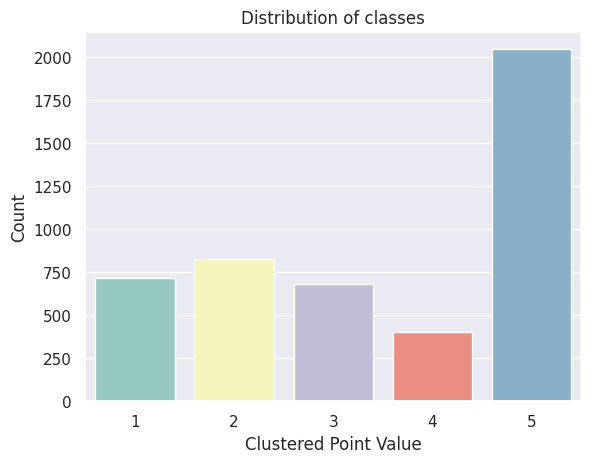

In [63]:
# Distribution of classes

# Custom color palette with 5 colors
custom_palette = ['#8DD3C7', '#FFFFB3', '#BEBADA', '#FB8072', '#80B1D3']

sns.set(style="darkgrid")

# Sort the DataFrame by 'cluster' before creating the countplot
compare_ref_cluster_pd_sorted = compare_ref_cluster_pd.sort_values(by='remapped')

# Using Seaborn's countplot to create a bar plot for the counts with the custom palette and sorted data
sns.countplot(data=compare_ref_cluster_pd_sorted, x='remapped', palette=custom_palette)

# Customize the plot
plt.xlabel('Clustered Point Value')
plt.ylabel('Count')
plt.title('Distribution of classes')

# Show the plot
plt.show()

### Visualising the distribution of classes for 8 classes k-means clusters

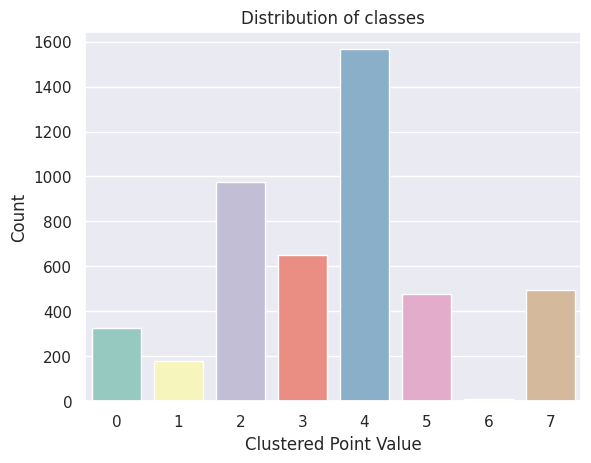

In [69]:
# Distribution of classes

# Custom color palette with 8 colors
custom_palette = ['#8DD3C7', '#FFFFB3', '#BEBADA', '#FB8072', '#80B1D3', '#eca3cb', '#c4c153', '#deb993']

sns.set(style="darkgrid")

# Sort the DataFrame by 'cluster' before creating the countplot
new_compare_ref_cluster_pd_sorted = new_compare_ref_cluster_pd.sort_values(by='cluster')

# Using Seaborn's countplot to create a bar plot for the counts with the custom palette and sorted data
sns.countplot(data=new_compare_ref_cluster_pd_sorted, x='cluster', palette=custom_palette)

# Customize the plot
plt.xlabel('Clustered Point Value')
plt.ylabel('Count')
plt.title('Distribution of classes')

# Show the plot
plt.show()

### Comparing clustered classes with each reference point landcover

Here we group the clustered reference points of the same landcover into separate dataframes to visualise as histograms. We expect to see one clustered class to be dominant for each Landcover class. However this in not the case with the result presented here. The clustering model can be improved.

In [73]:
filtered_lc_Water = (compare_ref_cluster_pd[compare_ref_cluster_pd['landcover'] == "Water"]).sort_values(by='remapped')
filtered_lc_ForestNaturalAreas = (compare_ref_cluster_pd[compare_ref_cluster_pd['landcover'] == "ForestNaturalAreas"]).sort_values(by='remapped')
filtered_lc_AgriculturalArea = (compare_ref_cluster_pd[compare_ref_cluster_pd['landcover'] == "AgriculturalArea"]).sort_values(by='remapped')
filtered_lc_Wetlands = (compare_ref_cluster_pd[compare_ref_cluster_pd['landcover'] == "Wetlands"]).sort_values(by='remapped')
filtered_lc_ArtificialSurfaces = (compare_ref_cluster_pd[compare_ref_cluster_pd['landcover'] == "ArtificialSurfaces"]).sort_values(by='remapped')

In [74]:
new_filtered_lc_Water = (new_compare_ref_cluster_pd[new_compare_ref_cluster_pd['landcover'] == "Water"]).sort_values(by='cluster')
new_filtered_lc_ForestNaturalAreas = (new_compare_ref_cluster_pd[new_compare_ref_cluster_pd['landcover'] == "ForestNaturalAreas"]).sort_values(by='cluster')
new_filtered_lc_AgriculturalArea = (new_compare_ref_cluster_pd[new_compare_ref_cluster_pd['landcover'] == "AgriculturalArea"]).sort_values(by='cluster')
new_filtered_lc_Wetlands = (new_compare_ref_cluster_pd[new_compare_ref_cluster_pd['landcover'] == "Wetlands"]).sort_values(by='cluster')
new_filtered_lc_ArtificialSurfaces = (new_compare_ref_cluster_pd[new_compare_ref_cluster_pd['landcover'] == "ArtificialSurfaces"]).sort_values(by='cluster')

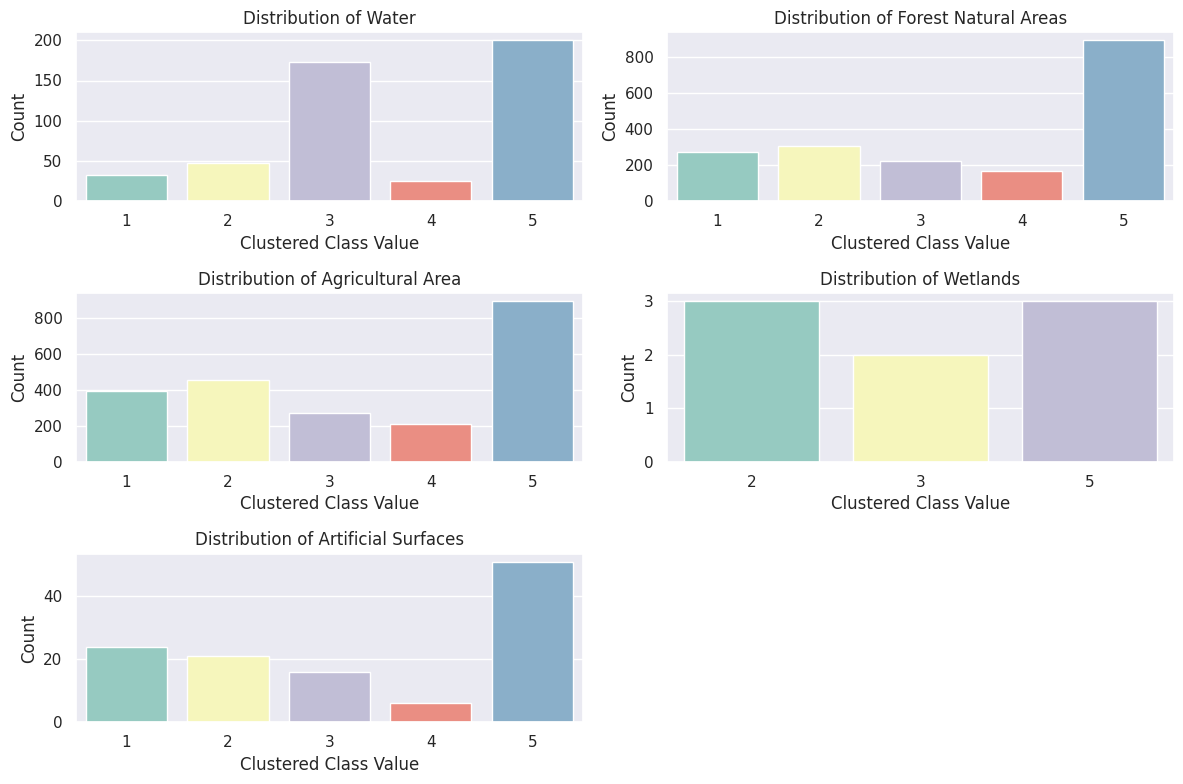

In [75]:
# Define your land cover categories and DataFrames
categories = ["Water", "Forest Natural Areas", "Agricultural Area", "Wetlands", "Artificial Surfaces"]
dataframes = [filtered_lc_Water, filtered_lc_ForestNaturalAreas, filtered_lc_AgriculturalArea, filtered_lc_Wetlands, filtered_lc_ArtificialSurfaces]
 
# Set the Seaborn style
sns.set(style="darkgrid")

custom_palette = ['#8DD3C7', '#FFFFB3', '#BEBADA', '#FB8072', '#80B1D3']
 
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
 
# Flatten the 2x2 grid to iterate through
axes = axes.flatten()
 
for i, (category, df) in enumerate(zip(categories, dataframes)):
    ax = sns.countplot(data=df, x='remapped', palette=custom_palette, ax=axes[i])
    ax.set_xlabel('Clustered Class Value')
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {category}')
 
if len(categories) % 2 == 1:
    fig.delaxes(axes[len(categories)])
 
plt.tight_layout()
plt.show()

From the above distribution, we can see that class 5 is dominant in all landcover grouped datasets. This mostly corresponds to water as there are many pixels over the ocean. However, we do not see one class dominating per landcover category. This maybe due to the model not being trained well. Or, this could also be due to the difference in time of classification of reference data and the summer 2023 image selected here.

NOTE: the y-axis ranges differently for each landcover graph

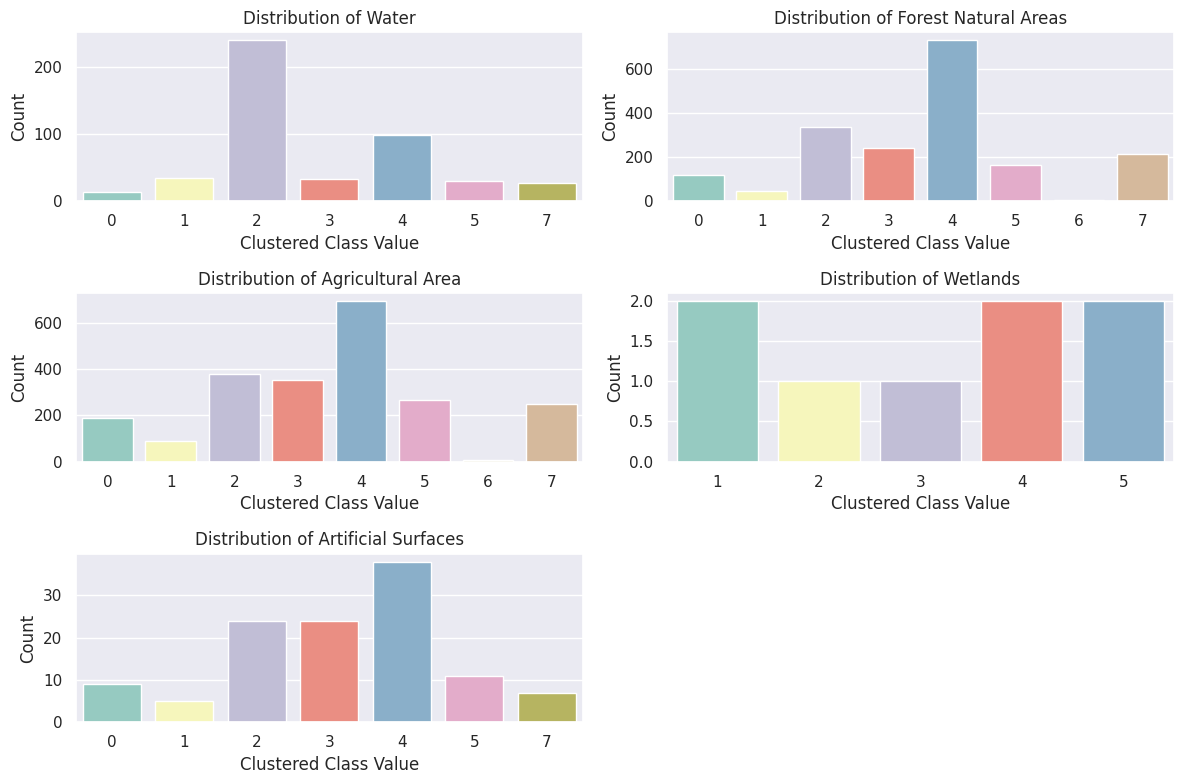

In [77]:
# FOR 8 CLASSES

# Define your land cover categories and DataFrames
categories = ["Water", "Forest Natural Areas", "Agricultural Area", "Wetlands", "Artificial Surfaces"]
dataframes = [new_filtered_lc_Water, new_filtered_lc_ForestNaturalAreas, new_filtered_lc_AgriculturalArea, new_filtered_lc_Wetlands, new_filtered_lc_ArtificialSurfaces]
 
# Set the Seaborn style
sns.set(style="darkgrid")

custom_palette = ['#8DD3C7', '#FFFFB3', '#BEBADA', '#FB8072', '#80B1D3', '#eca3cb', '#c4c153', '#deb993']
 
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
 
# Flatten the 2x2 grid to iterate through
axes = axes.flatten()
 
for i, (category, df) in enumerate(zip(categories, dataframes)):
    ax = sns.countplot(data=df, x='cluster', palette=custom_palette, ax=axes[i])
    ax.set_xlabel('Clustered Class Value')
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {category}')
 
if len(categories) % 2 == 1:
    fig.delaxes(axes[len(categories)])
 
plt.tight_layout()
plt.show()

For 8  classes k-means classification, we get more dominant classes than just one.

## Choosing a new region with the same clustering model

Here we use the earlier clusterer model of 5 classes to generate a clustering image for another nearby country with similar landcover - Albenia.

In [ ]:
# albenia_result = median_image.cluster(clusterer)

In [88]:
al_cbb = countrybb.country_bounding_boxes['AL'][1]
print(al_cbb)
# print (cbb[0], cbb[1], cbb[2], cbb[3])

al_roi = ee.Geometry.Rectangle(al_cbb[0], al_cbb[1], al_cbb[2], al_cbb[3])

(19.3044861183, 39.624997667, 21.0200403175, 42.6882473822)


In [89]:
al_ImCollection = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(al_roi) \
    .filterDate(ee.Date(start_date), ee.Date(end_date)) \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 2)

al_median_image = al_ImCollection.reduce(ee.Reducer.median())

bands = ['B2_median', 'B3_median', 'B4_median','B5_median', 'B6_median','B7_median', 'B8_median']
al_median_image = al_median_image.select(bands)

In [91]:
Map5 = geemap.Map()

Map5.centerObject(al_roi, 6)

Map5.addLayer(al_median_image, {
    'bands': ['B4_median', 'B3_median', 'B2_median'],  # Adjust bands as needed
    'min': 0,
    'max': 3000
}, 'Albenia Median Image')


Map5

Map(center=[41.14786945648861, 20.162263217900115], controls=(WidgetControl(options=['position', 'transparent_…

In [95]:
al_result = al_median_image.cluster(clusterer)

In [96]:
Map6 = geemap.Map()

Map6.centerObject(al_roi, 7)

legend_keys = ['One', 'Two', 'Three', 'Four', 'Five']
legend_colors = ['#8DD3C7', '#FFFFB3', '#BEBADA', '#FB8072', '#80B1D3']

# Reclassify the map
al_result = al_result.remap([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])

Map6.addLayer(al_result, {'min': 1, 'max': 5, 'palette': legend_colors}, 'Labelled clusters')
Map6.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright')

Map6

Map(center=[41.14786945648861, 20.162263217900115], controls=(WidgetControl(options=['position', 'transparent_…

As the landcover categories are quite similar Italy and Albenia, we have similar classification results and the model can be used for the country.